In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

In [2]:
# 读取四张表的数据
#读取了订单和产品id的关联，csv比较大
prior = pd.read_csv("./data/instacart/order_products__prior.csv")

In [3]:
#产品id，与过道的对应
products = pd.read_csv("./data/instacart/products.csv")

In [4]:
#订单id和用户id的对应，csv比较大
orders = pd.read_csv("./data/instacart/orders.csv")

In [5]:
#超市的过道，过道放的产品的品类
aisles = pd.read_csv("./data/instacart/aisles.csv")

In [6]:
prior.head()  #订单id，产品id，下面只需要掌握订单和产品的关联即可

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [7]:
products.head() #产品id，产品名称，过道id

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [8]:
orders.head() #订单id，用户id

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [9]:
aisles.head() #过道id，对应过道里放了哪些产品类别

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [10]:
# 合并四张表到一张表  （用户-物品类别），在这里挂了，用下阿里云
#订单表和产品表关联
#用户买了哪些订单，订单里面有哪些产品，产品对应的过道，过道对应的产品类别
_ = pd.merge(prior, products, on=['product_id', 'product_id'])
_mg = pd.merge(_, orders, on=['order_id', 'order_id'])
mt = pd.merge(_mg, aisles, on=['aisle_id', 'aisle_id'])

In [11]:
mt.head(10)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle
0,2,33120,1,1,Organic Egg Whites,86,16,202279,prior,3,5,9,8.0,eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,202279,prior,3,5,9,8.0,fresh vegetables
2,2,9327,3,0,Garlic Powder,104,13,202279,prior,3,5,9,8.0,spices seasonings
3,2,45918,4,1,Coconut Butter,19,13,202279,prior,3,5,9,8.0,oils vinegars
4,2,30035,5,0,Natural Sweetener,17,13,202279,prior,3,5,9,8.0,baking ingredients
5,2,17794,6,1,Carrots,83,4,202279,prior,3,5,9,8.0,fresh vegetables
6,2,40141,7,1,Original Unflavored Gelatine Mix,105,13,202279,prior,3,5,9,8.0,doughs gelatins bake mixes
7,2,1819,8,1,All Natural No Stir Creamy Almond Butter,88,13,202279,prior,3,5,9,8.0,spreads
8,2,43668,9,0,Classic Blend Cole Slaw,123,4,202279,prior,3,5,9,8.0,packaged vegetables fruits
9,3,33754,1,1,Total 2% with Strawberry Lowfat Greek Strained...,120,16,205970,prior,16,5,17,12.0,yogurt


In [12]:
mt.shape

(32434489, 14)

In [13]:
mt.isnull().sum()/mt.shape[0]  #数据缺失率，没有缺失值

order_id                  0.00000
product_id                0.00000
add_to_cart_order         0.00000
reordered                 0.00000
product_name              0.00000
aisle_id                  0.00000
department_id             0.00000
user_id                   0.00000
eval_set                  0.00000
order_number              0.00000
order_dow                 0.00000
order_hour_of_day         0.00000
days_since_prior_order    0.06407
aisle                     0.00000
dtype: float64

In [14]:
# 交叉表（特殊的分组工具），如果在这一步内存不够了，重启一下jupyter，还是不行，筛选一部分用户的数据，进行聚类
cross = pd.crosstab(mt['user_id'], mt['aisle'])

In [15]:
cross.head(10)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,3,0,0,0,0,2,0,0,0,...,3,1,1,0,0,0,0,2,0,42
3,0,0,0,0,0,0,0,0,0,0,...,4,1,0,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
5,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,5
8,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,6,0,2,0,0,0,...,0,0,0,0,0,0,0,2,0,19


In [16]:
#针对20万用户，有134个特征(代表超市里有134个过道）
cross.shape

(206209, 134)

In [17]:
type(cross)

pandas.DataFrame

In [20]:
# 进行主成分分析,那么大家还记得不？，保留90%的成分，实际特征数目减少了几倍，134 → 27
pca = PCA(n_components=0.9)

In [19]:
data = pca.fit_transform(cross)  #还记得fit_transform的作用不？
data.shape

(206209, 27)

In [21]:
type(data)

numpy.ndarray

In [22]:
# 把样本数量减少,为了下面画图方便，这里只取500个样本
x = data[:500]
x.shape

(500, 27)

In [23]:
x[0:10]

array([[-2.42156587e+01, -2.42942720e+00, -2.46636975e+00,
         1.45686388e-01,  2.69042476e-01, -1.43293209e+00,
        -2.14067666e+00,  2.73803122e+00, -2.71431623e+00,
        -1.74313529e+00, -1.13632718e+00,  6.73601069e-01,
        -1.65070735e+00,  2.83802486e+00,  5.89384489e+00,
        -7.84312891e+00, -4.84010146e+00, -3.22598697e+00,
        -4.58007571e+00,  7.77403349e-01, -3.69912893e+00,
         1.90721439e+00, -2.99538594e+00, -7.72922878e-01,
         6.86800336e-01,  1.69439402e+00, -2.34323022e+00],
       [ 6.46320806e+00, -3.67511165e+01,  8.38255336e+00,
        -1.50975303e+01, -6.92093785e+00, -9.78375183e-01,
        -6.01156653e+00, -3.78772465e+00, -8.18074883e+00,
        -9.04086141e+00, -5.61352902e+00, -1.11325323e+00,
         2.96702911e+00, -4.73123497e+00, -9.11472283e+00,
        -2.14709471e-01,  1.29694031e+00, -7.37605505e-01,
        -7.37401979e-01,  7.40042249e-01, -9.13382968e-02,
         5.15128465e+00,  4.58481528e+00,  3.23789431e+

In [24]:
x.max()

np.float64(407.18563418249795)

In [25]:
x.min()

np.float64(-144.56766126863647)

In [26]:
# 假设用户一共分为四个类别
#n_clusters是分为几个类别，是主要的超参
km = KMeans(n_clusters=4)

In [27]:
km.fit(x)  #开始训练

,"n_clusters n_clusters: int, default=8The number of clusters to form as well as the number ofcentroids to generate.For an example of how to choose an optimal value for `n_clusters` refer to:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_silhouette_analysis.py`.",4
,"init init: {'k-means++', 'random'}, callable or array-like of shape (n_clusters, n_features), default='k-means++'Method for initialization:* 'k-means++' : selects initial cluster centroids using sampling based on an empirical probability distribution of the points' contribution to the overall inertia. This technique speeds up convergence. The algorithm implemented is ""greedy k-means++"". It differs from the vanilla k-means++ by making several trials at each sampling step and choosing the best centroid among them.* 'random': choose `n_clusters` observations (rows) at random from data for the initial centroids.* If an array is passed, it should be of shape (n_clusters, n_features) and gives the initial centers.* If a callable is passed, it should take arguments X, n_clusters and a random state and return an initialization.For an example of how to use the different `init` strategies, see:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_digits.py`.For an evaluation of the impact of initialization, see the example:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_stability_low_dim_dense.py`.",'k-means++'
,"n_init n_init: 'auto' or int, default='auto'Number of times the k-means algorithm is run with different centroidseeds. The final results is the best output of `n_init` consecutive runsin terms of inertia. Several runs are recommended for sparsehigh-dimensional problems (see :ref:`kmeans_sparse_high_dim`).When `n_init='auto'`, the number of runs depends on the value of init:10 if using `init='random'` or `init` is a callable;1 if using `init='k-means++'` or `init` is an array-like... versionadded:: 1.2 Added 'auto' option for `n_init`... versionchanged:: 1.4 Default value for `n_init` changed to `'auto'`.",'auto'
,"max_iter max_iter: int, default=300Maximum number of iterations of the k-means algorithm for asingle run.",300
,"tol tol: float, default=1e-4Relative tolerance with regards to Frobenius norm of the differencein the cluster centers of two consecutive iterations to declareconvergence.",0.0001
,"verbose verbose: int, default=0Verbosity mode.",0
,"random_state random_state: int, RandomState instance or None, default=NoneDetermines random number generation for centroid initialization. Usean int to make the randomness deterministic.See :term:`Glossary `.",None
,"copy_x copy_x: bool, default=TrueWhen pre-computing distances it is more numerically accurate to centerthe data first. If copy_x is True (default), then the original data isnot modified. If False, the original data is modified, and put backbefore the function returns, but small numerical differences may beintroduced by subtracting and then adding the data mean. Note that ifthe original data is not C-contiguous, a copy will be made even ifcopy_x is False. If the original data is sparse, but not in CSR format,a copy will be made even if copy_x is False.",True
,"algorithm algorithm: {""lloyd"", ""elkan""}, default=""lloyd""K-means algorithm to use. The classical EM-style algorithm is `""lloyd""`.The `""elkan""` variation can be more efficient on some datasets withwell-defined clusters, by using the triangle inequality. However it'smore memory intensive due to the allocation of an extra array of shape`(n_samples, n_clusters)`... versionchanged:: 0.18 Added Elkan algorithm.. versionchanged:: 1.1 Renamed ""full"" to ""lloyd"", and deprecated ""auto"" and ""full"". Changed ""auto"" to use ""lloyd"" instead of ""elkan"".",'lloyd'


In [28]:
#开始预测
predict = km.predict(x)

In [29]:
print(predict)  #预测得到的是每一个样本的类别

[1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1
 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 2 1 0 0 1 1 0 1 1
 1 1 1 0 0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 2 1 0 1 1 0 2 1 1 1 2 1 0 1 1 0 1 0 0
 2 1 1 1 2 1 1 1 1 2 0 0 1 0 1 1 1 1 1 1 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 2 1 1 0 1 1 1 1 2 0 1 1 1 1 0 1
 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 2 1 1 1 1 1 1 1 2 1 2 1 1 1 2 1 1 1 1 0 1
 2 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0
 1 1 2 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1 0 1 0 1 2 1 1 1 1 0 1 1 1 1
 1 2 0 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 3
 1 1 1 0 1 0 0 0 1 0 1 1 1 1 1 1 1 2 1 2 0 2 1 1 1 1 1 1 1 1 1 0 1 1 1 1 2
 1 1 1 1 0 0 1 1 1 1 1 1 

In [30]:
import numpy as np
np.unique(predict)

array([0, 1, 2, 3], dtype=int32)

In [31]:
# 显示聚类的结果
plt.figure(figsize=(20, 20))

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

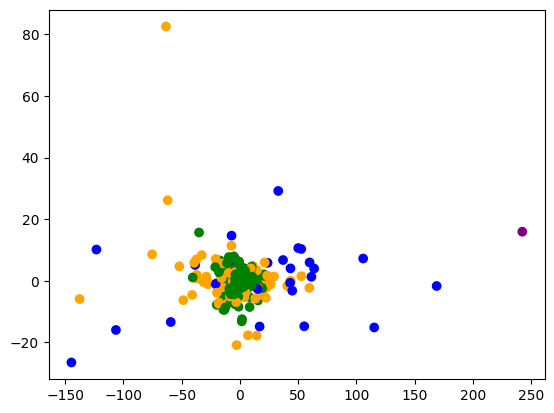

In [37]:
# 建立四个颜色的列表
colored = ['orange', 'green', 'blue', 'purple']
colr = [colored[i] for i in predict] #根据类别给每个样本赋予颜色
#去选择任意两个特征来看聚类的图，可以自行调整,第2个，第20个特征
plt.scatter(x[:, 1], x[:, 19], color=colr)


In [54]:
# 评判聚类效果，轮廓系数，聚类效果很难超过0.7，可以通过这个得分去调整上面KMeans的n_clusters
silhouette_score(x, predict)

0.5090700940190228

In [55]:
#改为2时的结果
km = KMeans(n_clusters=3)
km.fit(x)  #开始训练
predict = km.predict(x)
print(silhouette_score(x, predict))
predict

0.6377392240924094


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 1, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0,
       0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [56]:
# 通过分类后数据，去看原始样本的特点
cross.iloc[0]

aisle
air fresheners candles           0
asian foods                      0
baby accessories                 0
baby bath body care              0
baby food formula                0
                                ..
trash bags liners                0
vitamins supplements             0
water seltzer sparkling water    0
white wines                      0
yogurt                           1
Name: 1, Length: 134, dtype: int64

In [59]:
predict[26]
cross.iloc[26]

aisle
air fresheners candles             0
asian foods                        4
baby accessories                   0
baby bath body care                0
baby food formula                  0
                                ... 
trash bags liners                  0
vitamins supplements               0
water seltzer sparkling water     92
white wines                        0
yogurt                           150
Name: 27, Length: 134, dtype: int64

In [108]:
#改为3时的结果
km = KMeans(n_clusters=3)
km.fit(x)  #开始训练
predict = km.predict(x)
silhouette_score(x, predict)

0.666266223461154

# 四种异常值检测的方法

## 1.基于分位数找异常值

In [109]:
np.random.seed(42)  # 为了结果的可重复性设置随机种子
X = np.random.rand(50, 1)  # 2维数据
X

array([[0.37454012],
       [0.95071431],
       [0.73199394],
       [0.59865848],
       [0.15601864],
       [0.15599452],
       [0.05808361],
       [0.86617615],
       [0.60111501],
       [0.70807258],
       [0.02058449],
       [0.96990985],
       [0.83244264],
       [0.21233911],
       [0.18182497],
       [0.18340451],
       [0.30424224],
       [0.52475643],
       [0.43194502],
       [0.29122914],
       [0.61185289],
       [0.13949386],
       [0.29214465],
       [0.36636184],
       [0.45606998],
       [0.78517596],
       [0.19967378],
       [0.51423444],
       [0.59241457],
       [0.04645041],
       [0.60754485],
       [0.17052412],
       [0.06505159],
       [0.94888554],
       [0.96563203],
       [0.80839735],
       [0.30461377],
       [0.09767211],
       [0.68423303],
       [0.44015249],
       [0.12203823],
       [0.49517691],
       [0.03438852],
       [0.9093204 ],
       [0.25877998],
       [0.66252228],
       [0.31171108],
       [0.520

In [110]:
X.shape

(50, 1)

In [111]:
X[0,0]=3
X[1,0]=2

In [113]:
import pandas as pd

# 假设df是一个Pandas DataFrame，包含了你想要分析的数据集
# 'column_name'是你想要检测异常值的列名

#随机一个dataframe
df=pd.DataFrame(X,columns=['column_name'])

# 设置分位数，例如四分位数
Q1 = df['column_name'].quantile(0.25)  # 第一四分位数（25%）
Q3 = df['column_name'].quantile(0.75)  # 第三四分位数（75%）

# 计算四分位数范围（IQR）
IQR = Q3 - Q1

# 定义下界和上界来识别异常值
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 标记异常值
df['outlier'] = df['column_name'].apply(lambda x: 'Yes' if x < lower_bound or x > upper_bound else 'No')

# 打印出被标记为异常值的行
df[df['outlier'] == 'Yes']


,column_name,outlier
0,3.0,Yes
1,2.0,Yes


## 3.基于DBSCAN算法找异常值

(1600, 2)


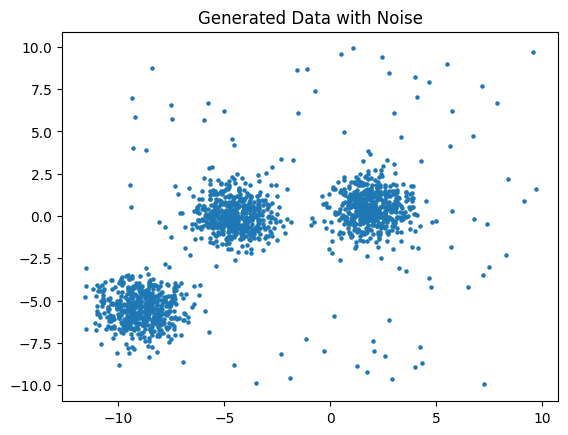

In [115]:
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs

# 生成样本数据
n_samples = 1500
random_state = 170
#生成1500个样本点
X, y = make_blobs(n_samples=n_samples, random_state=random_state) 
#返回的 X 是形状为 (1500, 2) 的数组，包含点的坐标；y 是每个点所属簇的标签（此处未使用）。
# 增加一些噪声点，往X中拼接噪声点
rng = np.random.RandomState(74)
#生成 100 个在 [-10, 10] 区间内均匀分布的二维随机点，作为噪声
X = np.concatenate([X, rng.uniform(low=-10, high=10, size=(100, 2))])
print(X.shape) #1600个样本，2列特征，100个噪声点
# 可视化生成的数据
plt.scatter(X[:, 0], X[:, 1], s=5) #取 X 的第一列和第二列，画散点图
plt.title("Generated Data with Noise")
plt.show()

In [116]:
X[0:5]

array([[ -5.19811282,   0.64186932],
       [ -5.75229538,   0.41862711],
       [-10.84489837,  -7.55352273],
       [ -4.57098483,  -0.80101741],
       [ -3.51916215,   0.0393449 ]])

[-1  0  1  2]
131
[0 1 2]


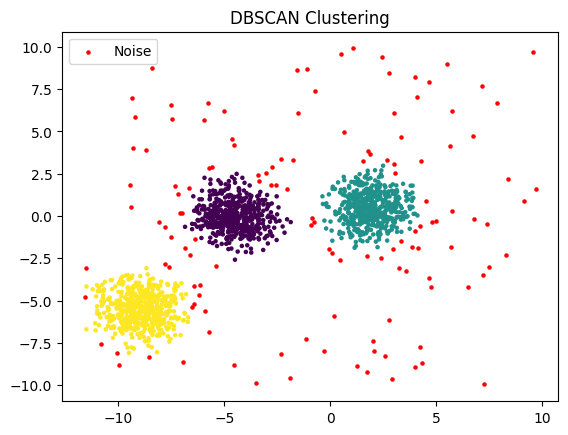

In [129]:
# 使用DBSCAN算法
db = DBSCAN(eps=0.5, min_samples=5).fit(X) # eps是半径，min_samples是最少包含几个点才会被认为是核心点
labels = db.labels_ # 得到每个点的类别
print(np.unique(labels)) # 得到类别有-1 0 1 2 总计 4 个类别
# 标签为-1的点是噪声点
noise_mask = (labels == -1)
print(np.sum(noise_mask)) # 噪声点的数量
print(np.unique(labels[~noise_mask])) # 得到噪声点的mask
# 可视化聚类结果
plt.scatter(X[~noise_mask, 0], X[~noise_mask, 1], c=labels[~noise_mask], s=5, cmap='viridis') # 正常点用彩色标注
plt.scatter(X[noise_mask, 0], X[noise_mask, 1], c='red', s=5, label='Noise') # 噪声点用红色标注
plt.title("DBSCAN Clustering")
plt.legend()
plt.show()


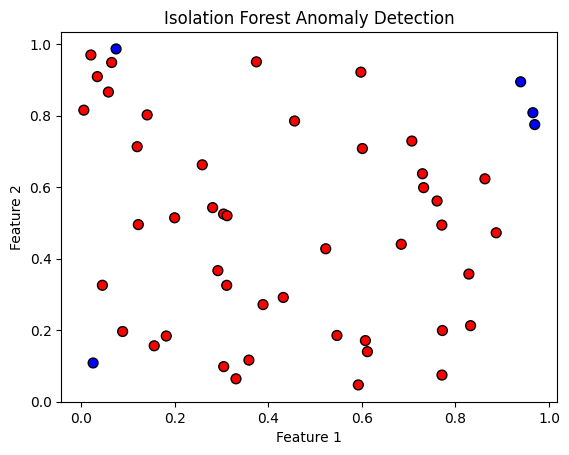

In [130]:
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# 随机生成 50个数据点
np.random.seed(42)  # 为了结果的可重复性设置随机种子
X = np.random.rand(50, 2)  # 2维数据,2列好画图来解释

# 初始化Isolation Forest模型，contamination参数表示异常值比例，默认0.1
iso_forest = IsolationForest(random_state=42, contamination=0.1)

# 训练模型，随机建树的过程
iso_forest.fit(X)

# 预测每个点的异常分数，在树中的高度越低，越可能是异常点
scores = iso_forest.decision_function(X)

# print(scores)
# 将异常分数转换为1（正常）和-1（异常）的标签
labels = iso_forest.predict(X)
# print(labels)
# 绘制数据点和异常点
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap=plt.cm.bwr, edgecolor='k', s=50)
plt.title('Isolation Forest Anomaly Detection')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [131]:
#把 scores和 labels拼接到一起
df=pd.DataFrame(np.c_[X,scores,labels],columns=['Feature 1','Feature 2','scores','labels'])
df

,Feature 1,Feature 2,scores,labels
0,0.374540,0.950714,0.001053,1.0
1,0.731994,0.598658,0.100556,1.0
2,0.156019,0.155995,0.053615,1.0
3,0.058084,0.866176,0.050242,1.0
4,0.601115,0.708073,0.071848,1.0
5,0.020584,0.969910,0.004049,1.0
6,0.832443,0.212339,0.019976,1.0
7,0.181825,0.183405,0.062738,1.0
8,0.304242,0.524756,0.108842,1.0
9,0.431945,0.291229,0.078362,1.0


In [132]:
labels[labels==-1]

array([-1, -1, -1, -1, -1])